# 卷积神经网络（LeNet）

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)  # 把图片展成28*28的

In [10]:
net = torch.nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size = 5, padding = 2), nn.Sigmoid(), # 把边缘删掉，用padding；得到非线性信息用sigmoid
    nn.AvgPool2d(2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), nn.Sigmoid(),   # 通道数变多变为6，压缩到了14 * 14
    nn.AvgPool2d(kernel_size = 2, stride = 2), nn.Flatten(),
    nn.Linear( 16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [14]:
X = torch.rand(size = (1, 1, 28, 28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练

In [17]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [26]:
# 使用GPU计算模型在数据集上的精度
def evaluate_accuracy_gpu(net, data_iter, device = None):
    # 判断 net 是否为 torch.nn.Module 类的实例
    # torch.nn.Module 是 PyTorch 中所有神经网络模块的基类
    if isinstance(net, torch.nn.Module):
        # 将网络设置为评估模式
        # 在评估模式下，一些特定的层（如 Dropout、BatchNorm 等）会改变其行为
        # 例如，Dropout 层在评估模式下不会随机丢弃神经元，BatchNorm 层会使用全局统计信息
        net.eval()
        # 如果没有指定设备（device 为 None）
        if not device:
            # 获取网络中第一个可训练参数所在的设备
            # next(iter(net.parameters())) 会返回网络的第一个参数
            # .device 属性可以获取该参数所在的设备（如 CPU 或 GPU）
            device = next(iter(net.parameters())).device
    
    # 创建一个累加器对象，用于累加正确预测的数量和样本总数
    # d2l.Accumulator(2) 表示该累加器可以存储两个值
    metric = d2l.Accumulator(2)
    
    # 遍历数据迭代器中的每个批次
    for X, y in data_iter:
        # 判断输入 X 是否为列表类型
        if isinstance(X, list):
            # 如果 X 是列表，将列表中的每个元素移动到指定设备上
            X = [x.to(device) for x in X]
        else:
            # 如果 X 不是列表，直接将 X 移动到指定设备上
            X = X.to(device)
        
        # 将标签 y 移动到指定设备上
        y = y.to(device)
        
        # 调用 net(X) 进行前向传播得到预测结果
        # d2l.accuracy 函数用于计算预测正确的样本数量
        # y.numel() 用于获取标签 y 中元素的总数（即当前批次的样本数量）
        # metric.add 方法将正确预测的数量和样本总数累加到累加器中
        metric.add(d2l.accuracy(net(X), y), y.numel())
    
    # 返回准确率，即正确预测的数量除以样本总数
    return metric[0] / metric[1]

In [46]:
# 用 GPU 训练模型的函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    # 定义一个初始化权重的函数
    def init_weights(m):
        # 判断当前层 m 是否为全连接层（nn.Linear）或者卷积层（nn.Conv2d）
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            # 使用 Xavier 均匀分布初始化该层的权重
            # Xavier 初始化有助于缓解梯度消失和梯度爆炸问题，使网络的训练更加稳定
            nn.init.xavier_uniform_(m.weight)
    # 对网络中的每一层应用 init_weights 函数进行权重初始化
    net.apply(init_weights)
    # 打印训练使用的设备信息
    print('training on', device)
    # 将网络模型移动到指定的设备（如 GPU）上
    net.to(device)
    # 定义优化器，这里使用随机梯度下降（SGD）优化器
    # 传入网络的参数和学习率 lr
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    # 定义损失函数，这里使用交叉熵损失函数，适用于多分类问题
    loss = nn.CrossEntropyLoss()
    # 创建一个动画绘制器对象 animator，用于可视化训练过程
    # xlabel 表示 x 轴的标签，xlim 表示 x 轴的范围，legend 表示图例
    animator = d2l.Animator(xlabel = 'epoch', xlim = [1, num_epochs], legend = ['train loss', 'train acc', 'test acc'])
    # 创建一个计时器对象 timer，用于记录训练时间
    # num_batches 表示训练数据迭代器中的批次数量
    timer, num_batches = d2l.Timer(), len(train_iter)
    # 开始训练的主循环，循环次数为 num_epochs
    for epoch in range(num_epochs):
        # 创建一个累加器对象 metric，用于累加训练过程中的损失、正确预测的样本数和样本总数
        metric = d2l.Accumulator(3)
        # 将网络设置为训练模式
        # 一些特定的层（如 Dropout、BatchNorm 等）在训练模式和评估模式下的行为不同
        net.train()
        # 遍历训练数据迭代器中的每个批次
        for i, (X, y) in enumerate(train_iter):
            # 开始计时
            timer.start()
            # 清空优化器中的梯度信息
            # 因为 PyTorch 会累积梯度，所以在每次反向传播之前需要清空梯度
            optimizer.zero_grad()
            # 将输入数据 X 和标签 y 移动到指定的设备上
            X, y = X.to(device), y.to(device)
            # 前向传播，通过网络模型得到预测结果
            y_hat = net(X)
            # 计算损失，使用定义好的交叉熵损失函数
            l = loss(y_hat, y)
            # 反向传播，计算梯度
            l.backward()
            # 根据计算得到的梯度更新网络的参数
            optimizer.step()
            # 累加损失、正确预测的样本数和样本总数到累加器中
            # l * X.shape[0] 是当前批次的总损失，d2l.accuracy(y_hat, y) 是当前批次的正确预测样本数，X.shape[0] 是当前批次的样本数
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            # 停止计时
            timer.stop()
            # 计算当前训练轮次的平均训练损失
            train_l = metric[0] / metric[2]
            # 计算当前训练轮次的训练准确率
            train_acc = metric[1] / metric[2]
            # 每训练完一定数量的批次（这里是总批次数量的五分之一）或者训练完最后一个批次时
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                # 将当前的训练损失、训练准确率添加到动画绘制器中
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        # 在每个训练轮次结束后，使用测试数据评估模型的准确率
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # 将测试准确率添加到动画绘制器中
        animator.add(epoch + 1, (None, None, test_acc))
    # 打印最终的训练损失、训练准确率和测试准确率
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    # 打印训练速度，即每秒处理的样本数
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.485, train acc 0.814, test acc 0.816
7366.3 examples/sec on cpu


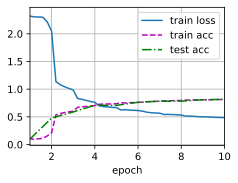

In [44]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())